# Model Refinement and Fine Tuning

## Cretaing Summary column as a combination of Short Description and Description

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# import spacy
import nltk
from nltk import tokenize
from nltk.corpus import stopwords
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
%matplotlib inline

/Users/kushalpatil/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kushalpatil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
ticket = pd.read_csv('preprocessed_ticket.csv')

In [3]:
ticket.insert(loc=8, column='Summary', allow_duplicates=True, value=list(ticket['Short description'].str.strip() + ' ' + ticket['Description'].str.strip()))

## Generating word2vec model

In [4]:
import re
import string
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# ps = PorterStemmer()
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
          
def clean_sentence(review):
    '''
    Input:
        review: a string containing a review.
    Output:
        review_cleaned: a processed review. 

    '''
    if str(review) != 'nan':
        plreview = "".join([char.lower() for char in review if char not in string.punctuation])
        text_tokens = word_tokenize(plreview)
        suplreview = " ".join([word for word in text_tokens if not word in stop_words])

        text_tokens = word_tokenize(suplreview)
        review_cleaned = [lemmatizer.lemmatize(word) for word in text_tokens]
        return review_cleaned
    else:
        return 'None'

sentence_list=[]
summary_list = ticket.Summary.values.tolist()
for sent in summary_list:
    sentence_list.append(clean_sentence(sent))

In [5]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser

phrases_bi = Phrases(sentence_list, min_count=2, threshold=2)
phrases_tri = Phrases(phrases_bi[sentence_list], min_count=2, threshold=1)
phraser_bi = Phraser(phrases_bi)
phraser_tri = Phraser(phrases_tri)
ngram_list=[]

for sent in sentence_list:
    tokens_ = phraser_bi[sent]
    tokens_ = phraser_tri[tokens_]
    ngram_list.append(tokens_)

In [6]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
documents = [TaggedDocument(words=doc, tags=[i]) for i, doc in enumerate(ngram_list)]

In [7]:
# Build the Word2Vec model
epochs = 100
vec_size = 300
alpha = 0.025
model = Doc2Vec(vector_size=vec_size,window=2,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=2,
                dm =1)
model.build_vocab(documents)

for epoch in range(epochs):
    model.train(documents, 
                total_examples=model.corpus_count,
                epochs=model.epochs)
    model.alpha -= 0.0002
    model.min_alpha = model.alpha

## Adding length of description to data

In [8]:
lines = ticket.Description.apply(lambda x: len(str(x).split('\n')))
ticket.insert(loc=ticket.shape[1]-1, column='Lines', value=lines)

## Further segmenting GRP_0 tickets since they are a majority

In [9]:
# Records assigned to only GRP_0
ticket_grp0 = ticket[ticket['Assignment group'] == 'GRP_0']

# Prepare NLTK STOPWORDS
STOP_WORDS = stopwords.words('english')
STOP_WORDS.extend(['yes','na','from','greeting','forward','reply','will','please','able','hi','receive','hello','regards','thanks','see','help'])


In [10]:
import gensim
from gensim.utils import simple_preprocess

def word_convert(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

word_list = list(word_convert(ticket_grp0['Summary'].values.tolist()))
word_list_nostops = [[word for word in simple_preprocess(str(doc)) if word not in STOP_WORDS] for doc in word_list]

In [11]:
bigram = gensim.models.Phrases(word_list, min_count=5, threshold=100) # higher threshold = fewer phrases.
trigram = gensim.models.Phrases(bigram[word_list], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
word_list_bigrams = [bigram_mod[doc] for doc in word_list_nostops]

trigram_mod = gensim.models.phrases.Phraser(trigram)
word_list_trigrams = [trigram_mod[doc] for doc in word_list_nostops]

In [12]:
import gensim.corpora as corpora
# Create word_list dictionary
index2word = corpora.Dictionary(word_list_bigrams)

# Term Document Frequency
corpus = [index2word.doc2bow(text) for text in word_list_bigrams]


## Using LDA for topic modeling

In [13]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=index2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

for idx, topic in lda_model.print_topics():
    print('Topic: {} \nWords: {}'.format(idx+1, topic))
    print()


Topic: 1 
Words: 0.031*"update" + 0.026*"user" + 0.025*"ticket" + 0.023*"issue" + 0.020*"connect" + 0.012*"login" + 0.012*"printer" + 0.011*"vpn" + 0.011*"network" + 0.011*"ticketno"

Topic: 2 
Words: 0.025*"unable" + 0.023*"outlook" + 0.018*"access" + 0.017*"email" + 0.015*"issue" + 0.014*"company" + 0.011*"skype" + 0.011*"error" + 0.009*"open" + 0.009*"device"

Topic: 3 
Words: 0.184*"xd" + 0.076*"password" + 0.054*"erp" + 0.049*"reset" + 0.043*"account" + 0.028*"sid" + 0.025*"locked" + 0.022*"login" + 0.022*"user" + 0.021*"received"



In [14]:
import pyLDAvis
import pyLDAvis.gensim_models
from IPython.display import IFrame
pyLDAvis.enable_notebook()
pyLDAvis.save_html(pyLDAvis.gensim_models.prepare(lda_model, corpus, index2word), 'lda.html')
IFrame(src='./lda.html', width=1220, height=858)

/Users/kushalpatil/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [15]:
topic_dict = {1:"Communication Issue", 2:"Account/Password Reset", 3:"Access Issue", 4:"Other Issues"}
def assign_grp(text):
    bow_vector = index2word.doc2bow([w for w in simple_preprocess(text) if w not in STOP_WORDS])
    index, score = sorted(lda_model[bow_vector][0], key=lambda tup: tup[1], reverse=True)[0]
    return topic_dict[index+1 if score > 0.5 else 4], round(score, 2)

In [16]:
ticket_grp0.insert(loc=ticket_grp0.shape[1]-1, 
                   column='Topic', 
                   value=[assign_grp(str(text))[0] for text in ticket_grp0.Summary])
ticket_grp0.head()

,Unnamed: 0,sd_len,sd_word_count,Short description,desc_len,desc_word_count,Description,Language,Summary,Caller,Lines,Topic,Assignment group
0,0,11,2,login issue,154,21,verified user detailsemployee manager namexd c...,en,login issue verified user detailsemployee mana...,spxjnwir pjlcoqds,1,Communication Issue,GRP_0
1,1,7,1,outlook,159,21,xd xd received hmjdrvpbkomuaywngmailcomxd xd h...,en,outlook xd xd received hmjdrvpbkomuaywngmailco...,hmjdrvpb komuaywn,1,Access Issue,GRP_0
2,2,12,3,cant log vpn,70,11,xd xd received eylqgodmybqkwiamgmailcomxd xd h...,en,cant log vpn xd xd received eylqgodmybqkwiamgm...,eylqgodm ybqkwiam,1,Access Issue,GRP_0
3,3,25,4,unable access hrtool page,25,4,unable access hrtool page,en,unable access hrtool page unable access hrtool...,xbkucsvz gcpydteq,1,Account/Password Reset,GRP_0
4,4,11,2,skype error,11,2,skype error,en,skype error skype error,owlgqjme qhcozdfx,1,Account/Password Reset,GRP_0


In [17]:
ticket_grp0.Topic.value_counts()

Account/Password Reset    1622
Access Issue              1463
Communication Issue        638
Other Issues               245
Name: Topic, dtype: int64

## Undersampling data to make the distibution normal

In [18]:
from imblearn.under_sampling import RandomUnderSampler
sampler = RandomUnderSampler(sampling_strategy='auto', random_state=0)
X_res, y_res = sampler.fit_resample(ticket_grp0.drop(['Assignment group','Topic'], axis=1), ticket_grp0.Topic)
y_res.value_counts()


Access Issue              245
Account/Password Reset    245
Communication Issue       245
Other Issues              245
Name: Topic, dtype: int64

In [19]:
ticket_grp0 = pd.concat([X_res, y_res], axis=1)
ticket_grp0['Assignment group'] = ticket_grp0['Topic'].apply(lambda x: f'GRP_0 ({x})')
ticket_grp0.drop(['Topic'], axis=1, inplace=True)
print(f"New size of GRP_0 tickets: {ticket_grp0.shape}")
ticket_grp0.head()

New size of GRP_0 tickets: (980, 12)


,Unnamed: 0,sd_len,sd_word_count,Short description,desc_len,desc_word_count,Description,Language,Summary,Caller,Lines,Assignment group
0,8442,22,4,password reset erp sid,22,4,password reset erp sid,NaN,password reset erp sid password reset erp sid,rcukxbvw pvnuqlyb,1,GRP_0 (Access Issue)
1,867,15,2,account lockout,15,2,account lockout,en,account lockout account lockout,wqfpkcgh vxtqeris,1,GRP_0 (Access Issue)
2,4404,14,2,siduser locked,14,2,siduser locked,en,siduser locked siduser locked,vhfucgar kwrstxqu,1,GRP_0 (Access Issue)
3,6519,24,4,erp login account locked,35,5,requesting unlock erp login account,NaN,erp login account locked requesting unlock erp...,wjsfbpuv lcpdfihr,1,GRP_0 (Access Issue)
4,150,43,7,reset password wseacnvi azvixyqg erp qa erp,45,7,please reset password sid blocked login jdhdw,en,reset password wseacnvi azvixyqg erp qa erp pl...,wseacnvi azvixyqg,1,GRP_0 (Access Issue)


## Combining minority groups as miscellaneous assignments

In [20]:
minority_tickets = ticket.groupby(['Assignment group']).filter(lambda x: len(x) <= 25)
minority_tickets['Assignment group'].value_counts()

GRP_23    25
GRP_48    25
GRP_62    25
GRP_60    20
GRP_39    19
GRP_27    18
GRP_37    16
GRP_44    15
GRP_36    15
GRP_50    14
GRP_65    11
GRP_53    11
GRP_52     9
GRP_55     8
GRP_51     8
GRP_46     6
GRP_59     6
GRP_49     6
GRP_43     5
GRP_66     4
GRP_32     4
GRP_63     3
GRP_68     3
GRP_56     3
GRP_58     3
GRP_38     3
GRP_57     2
GRP_54     2
GRP_69     2
GRP_71     2
GRP_72     2
GRP_61     1
GRP_64     1
GRP_67     1
GRP_35     1
GRP_70     1
GRP_73     1
Name: Assignment group, dtype: int64

In [21]:
minority_tickets['Assignment group'] = 'Miscellaneous'

## Combining undersampled and modified data to create new dataset

In [22]:
majority_tickets = ticket.iloc[[idx for idx in ticket.index if idx not in minority_tickets.index]]
majority_tickets = majority_tickets[majority_tickets['Assignment group'] != 'GRP_0']
ticket = pd.concat([ticket_grp0, majority_tickets, minority_tickets]).reset_index(drop=True)

In [23]:
print('Unique groups remaining: ', ticket['Assignment group'].nunique())

Unique groups remaining:  41


## Preparing input data for models

In [24]:
wmodel = model
w2v_weights = wmodel.wv.vectors
vocab_size, embedding_size = w2v_weights.shape
print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

Vocabulary Size: 14182 - Embedding Dim: 300


In [70]:
import re
import string
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
          
def clean_sentence2(review):
    '''
    Input:
        review: a string containing a review.
    Output:
        review_cleaned: a processed review. 

    '''
    if str(review) != 'nan':
        plreview = "".join([char.lower() for char in review if char not in string.punctuation])
        text_tokens = word_tokenize(plreview)
        suplreview = " ".join([word for word in text_tokens if not word in stop_words])

        text_tokens = word_tokenize(suplreview)
        review_cleaned = [lemmatizer.lemmatize(word) for word in text_tokens]
        r_c = " ".join([word for word in review_cleaned])
        return r_c
    else:
        return 'None'

In [63]:
def word2token(word):
    try:
        return wmodel.wv.vocab[word].index
    # If word is not in index return 0. I realize this means that this
    # is the same as the word of index 0 (i.e. most frequent word), but 0s
    # will be padded later anyway by the embedding layer (which also
    # seems dirty but I couldn't find a better solution right now)
    except KeyError:
        return 0

In [64]:
# Prepare the embbedings with 0's padding to max sequence length
X = ticket.Summary.values.tolist()
set_X=[]
for sent in X:
  #print(sent[0])
  set_X.append(np.array([word2token(w) for w in clean_sentence2(str(sent))[:MAX_SEQUENCE_LENGTH] if w != '']))

In [65]:
set_X

[array([1131,    0,    0,    0, 1079, 2356,  349,    0,    0,  349,   31,
           0,   31,    0,    0,   31,  349, 1131,    0,    0,    0,    0,
           0, 1131,    0,    0,    0, 1079, 2356,  349,    0,    0,  349,
          31,    0,   31,    0,    0,   31,  349, 1131,    0,    0,    0,
           0]),
 array([   0,  109,  109, 2356,  143, 2660,    0,    0, 1881, 2356,  109,
         905, 2356,  143,    0,    0,    0,  109,  109, 2356,  143, 2660,
           0,    0, 1881, 2356,  109,  905, 2356,  143,    0]),
 array([   0,    0,    0,  143,    0,   31,  349,    0, 1881, 2356,  109,
         905,   31,    0,    0,    0,    0,    0,  143,    0,   31,  349,
           0, 1881, 2356,  109,  905,   31,    0]),
 array([  31,  349, 1131,    0, 1881, 2356,  473,    0, 2660,    0,    0,
         109,  109, 2356,  143, 2660,    0,    0, 1881, 2356,  109,  905,
          31,    0,    0,  349,   31,  785,  143,   31,    0,    0,    0,
        2660,  473,    0,  143, 2660, 1881, 2356,  109

In [73]:
from keras_preprocessing.sequence import pad_sequences
MAX_SEQUENCE_LENGTH = 75

X = [clean_sentence2(str(x)) for x in ticket.Summary.values.tolist()]
tokenizer = text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X)
seq_token = tokenizer.texts_to_sequences(X)
g = sequence.pad_sequences(seq_token, maxlen=MAX_SEQUENCE_LENGTH,padding='pre',value=0)

y = pd.get_dummies(ticket['Assignment group']).values
print(g)

[[   0    0    0 ...   28    8   24]
 [   0    0    0 ... 1310   32 1310]
 [   0    0    0 ...  136 2491  136]
 ...
 [   0    0    0 ... 7239 7238 7239]
 [   0    0    0 ... 5718 2917   29]
 [   0    0    0 ...  293 1400 2590]]


In [77]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(g, y, test_size=0.3, random_state=47)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3852, 75), (1651, 75), (3852, 41), (1651, 41))

In [75]:
from keras.models import Sequential, Model
from keras.layers import Concatenate
from keras.layers import Input, Dropout, Flatten, Dense, Embedding, LSTM, GRU
from keras.layers import BatchNormalization, TimeDistributed, Conv1D, MaxPooling1D
from tensorflow.keras.layers import SpatialDropout1D
from keras.callbacks import EarlyStopping, ModelCheckpoint

DROP_THRESHOLD = 10000
model_seq = Sequential()
model_seq.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_size, 
                        weights=[w2v_weights], 
                        input_length=MAX_SEQUENCE_LENGTH, 
                        mask_zero=True,
                        trainable=False))
model_seq.add(SpatialDropout1D(0.2))
model_seq.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_seq.add(Dense(41, activation='softmax'))
model_seq.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 20
batch_size = 64

history = model_seq.fit(X_train, 
                        y_train, 
                        epochs=epochs, 
                        batch_size=batch_size,
                        validation_split=0.1)

Epoch 1/20
55/55 [==============================] - 8s 123ms/step - loss: 3.2077 - accuracy: 0.1875 - val_loss: 2.8547 - val_accuracy: 0.2642
Epoch 2/20
55/55 [==============================] - 7s 121ms/step - loss: 2.7358 - accuracy: 0.3041 - val_loss: 2.6100 - val_accuracy: 0.2953
Epoch 3/20
55/55 [==============================] - 7s 122ms/step - loss: 2.4344 - accuracy: 0.3529 - val_loss: 2.4237 - val_accuracy: 0.3523
Epoch 4/20
55/55 [==============================] - 7s 121ms/step - loss: 2.2246 - accuracy: 0.3918 - val_loss: 2.2511 - val_accuracy: 0.3756
Epoch 5/20
55/55 [==============================] - 7s 121ms/step - loss: 2.0525 - accuracy: 0.4383 - val_loss: 2.1304 - val_accuracy: 0.3886
Epoch 6/20
55/55 [==============================] - 8s 138ms/step - loss: 1.9121 - accuracy: 0.4683 - val_loss: 2.0731 - val_accuracy: 0.4171
Epoch 7/20
55/55 [==============================] - 7s 133ms/step - loss: 1.7847 - accuracy: 0.5012 - val_loss: 2.0150 - val_accuracy: 0.3964
Epoch 

## Changing dropout value

In [50]:
model_seq = Sequential()
model_seq.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_size, 
                        weights=[w2v_weights], 
                        input_length=MAX_SEQUENCE_LENGTH, 
                        mask_zero=True,
                        trainable=False))
model_seq.add(SpatialDropout1D(0.1))
model_seq.add(LSTM(100, dropout=0.1, recurrent_dropout=0.1))
model_seq.add(Dense(41, activation='softmax'))
model_seq.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model_seq.fit(X_train, 
                        y_train, 
                        epochs=epochs, 
                        batch_size=batch_size,
                        validation_split=0.1)

Epoch 1/20
55/55 [==============================] - 13s 204ms/step - loss: 3.1140 - accuracy: 0.2132 - val_loss: 2.8024 - val_accuracy: 0.2720
Epoch 2/20
55/55 [==============================] - 13s 231ms/step - loss: 2.5905 - accuracy: 0.3234 - val_loss: 2.5336 - val_accuracy: 0.3005
Epoch 3/20
55/55 [==============================] - 12s 210ms/step - loss: 2.2880 - accuracy: 0.3832 - val_loss: 2.3097 - val_accuracy: 0.3472
Epoch 4/20
55/55 [==============================] - 10s 187ms/step - loss: 2.0501 - accuracy: 0.4391 - val_loss: 2.1747 - val_accuracy: 0.3472
Epoch 5/20
55/55 [==============================] - 12s 210ms/step - loss: 1.8336 - accuracy: 0.4942 - val_loss: 2.1115 - val_accuracy: 0.3860
Epoch 6/20
55/55 [==============================] - 12s 212ms/step - loss: 1.6677 - accuracy: 0.5349 - val_loss: 2.0287 - val_accuracy: 0.4197
Epoch 7/20
55/55 [==============================] - 9s 169ms/step - loss: 1.5167 - accuracy: 0.5753 - val_loss: 1.9765 - val_accuracy: 0.4275


## Adding core to LSTM

In [51]:
model_seq = Sequential()
model_seq.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_size, 
                        weights=[w2v_weights], 
                        input_length=MAX_SEQUENCE_LENGTH, 
                        mask_zero=True,
                        trainable=False))
model_seq.add(SpatialDropout1D(0.1))
model_seq.add(LSTM(150, dropout=0.1, recurrent_dropout=0.1))
model_seq.add(Dense(41, activation='softmax'))
model_seq.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model_seq.fit(X_train, 
                        y_train, 
                        epochs=epochs, 
                        batch_size=batch_size,
                        validation_split=0.1)

Epoch 1/20
55/55 [==============================] - 14s 220ms/step - loss: 3.0397 - accuracy: 0.2271 - val_loss: 2.6782 - val_accuracy: 0.2694
Epoch 2/20
55/55 [==============================] - 13s 231ms/step - loss: 2.4466 - accuracy: 0.3488 - val_loss: 2.3374 - val_accuracy: 0.3187
Epoch 3/20
55/55 [==============================] - 13s 236ms/step - loss: 2.0681 - accuracy: 0.4276 - val_loss: 2.1788 - val_accuracy: 0.3834
Epoch 4/20
55/55 [==============================] - 12s 225ms/step - loss: 1.8040 - accuracy: 0.5000 - val_loss: 2.0393 - val_accuracy: 0.4145
Epoch 5/20
55/55 [==============================] - 13s 237ms/step - loss: 1.5912 - accuracy: 0.5525 - val_loss: 2.0331 - val_accuracy: 0.4093
Epoch 6/20
55/55 [==============================] - 12s 216ms/step - loss: 1.4238 - accuracy: 0.6044 - val_loss: 1.9538 - val_accuracy: 0.4404
Epoch 7/20
55/55 [==============================] - 12s 224ms/step - loss: 1.2822 - accuracy: 0.6313 - val_loss: 1.9330 - val_accuracy: 0.4275

/Users/kushalpatil/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/kushalpatil/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/scipy/stats/stats.py:2857: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  pct = percentile_func(x, rng, axis=axis, interpolation=interpolation,


52/52 [==============================] - 2s 40ms/step - loss: 2.3250 - accuracy: 0.4518
Test set Loss: 2.325,  Accuracy: 45.185


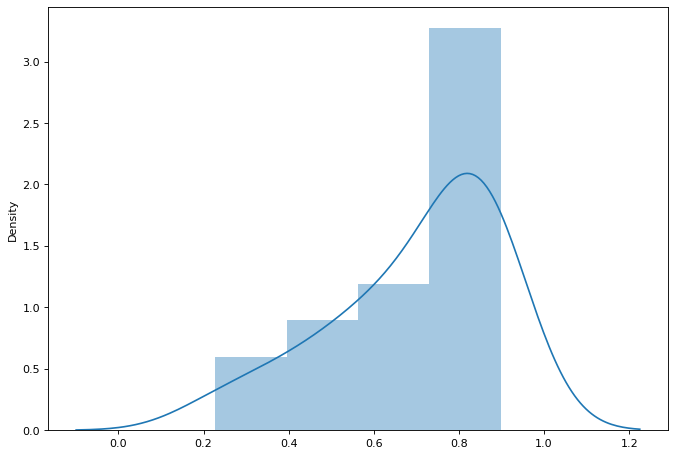

In [52]:
acc = history.history['accuracy']
plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(acc)
accr = model_seq.evaluate(X_test,y_test)
print('Test set Loss: {:0.3f},  Accuracy: {:0.3f}'.format(accr[0],accr[1]*100))

## adding a dense and dropout and batch normalistaion layer

In [53]:
model_seq = Sequential()
model_seq.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_size, 
                        weights=[w2v_weights], 
                        input_length=MAX_SEQUENCE_LENGTH, 
                        mask_zero=True,
                        trainable=False))
model_seq.add(SpatialDropout1D(0.1))
model_seq.add(LSTM(150, dropout=0.1, recurrent_dropout=0.1))
model_seq.add(Dense(150, activation='relu'))
model_seq.add(BatchNormalization(momentum=0.8,epsilon=0.02))
model_seq.add(Dropout(0.1))
model_seq.add(Dense(41, activation='softmax'))
model_seq.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model_seq.fit(X_train, 
                        y_train, 
                        epochs=epochs, 
                        batch_size=batch_size,
                        validation_split=0.1)

Epoch 1/20
55/55 [==============================] - 16s 232ms/step - loss: 3.0920 - accuracy: 0.2245 - val_loss: 2.7149 - val_accuracy: 0.2876
Epoch 2/20
55/55 [==============================] - 12s 215ms/step - loss: 2.4792 - accuracy: 0.3459 - val_loss: 2.4158 - val_accuracy: 0.3264
Epoch 3/20
55/55 [==============================] - 12s 219ms/step - loss: 2.1539 - accuracy: 0.4117 - val_loss: 2.3335 - val_accuracy: 0.3187
Epoch 4/20
55/55 [==============================] - 12s 226ms/step - loss: 1.8702 - accuracy: 0.4700 - val_loss: 2.2886 - val_accuracy: 0.3368
Epoch 5/20
55/55 [==============================] - 12s 225ms/step - loss: 1.6140 - accuracy: 0.5413 - val_loss: 2.2056 - val_accuracy: 0.4093
Epoch 6/20
55/55 [==============================] - 13s 229ms/step - loss: 1.4129 - accuracy: 0.5964 - val_loss: 2.2217 - val_accuracy: 0.3938
Epoch 7/20
55/55 [==============================] - 13s 228ms/step - loss: 1.2419 - accuracy: 0.6448 - val_loss: 2.2862 - val_accuracy: 0.4249

## Adam optimization

In [78]:
from keras.optimizers import Adam

adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)

model_seq = Sequential()
model_seq.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_size, 
                        weights=[w2v_weights], 
                        input_length=MAX_SEQUENCE_LENGTH, 
                        mask_zero=True,
                        trainable=False))
model_seq.add(SpatialDropout1D(0.1))
model_seq.add(LSTM(150, dropout=0.1, recurrent_dropout=0.1))
model_seq.add(Dense(150, activation='relu'))
model_seq.add(BatchNormalization(momentum=0.4,epsilon=0.02))
model_seq.add(Dropout(0.1))
model_seq.add(Dense(41, activation='softmax'))
model_seq.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

history = model_seq.fit(X_train, 
                        y_train, 
                        epochs=epochs, 
                        batch_size=batch_size,
                        validation_split=0.1)

Epoch 1/20
55/55 [==============================] - 15s 200ms/step - loss: 3.0518 - accuracy: 0.2274 - val_loss: 2.7984 - val_accuracy: 0.2668
Epoch 2/20
55/55 [==============================] - 11s 195ms/step - loss: 2.4788 - accuracy: 0.3358 - val_loss: 2.5079 - val_accuracy: 0.3135
Epoch 3/20
55/55 [==============================] - 11s 194ms/step - loss: 2.1337 - accuracy: 0.4100 - val_loss: 2.3120 - val_accuracy: 0.3420
Epoch 4/20
55/55 [==============================] - 11s 198ms/step - loss: 1.8637 - accuracy: 0.4703 - val_loss: 2.2286 - val_accuracy: 0.3705
Epoch 5/20
55/55 [==============================] - 12s 216ms/step - loss: 1.6223 - accuracy: 0.5415 - val_loss: 2.1245 - val_accuracy: 0.4197
Epoch 6/20
55/55 [==============================] - 11s 206ms/step - loss: 1.3801 - accuracy: 0.6073 - val_loss: 2.1739 - val_accuracy: 0.3938
Epoch 7/20
55/55 [==============================] - 11s 204ms/step - loss: 1.2029 - accuracy: 0.6610 - val_loss: 2.1588 - val_accuracy: 0.4352

In [55]:
accr = model_seq.evaluate(X_test,y_test)
print('Test set  Loss: {:0.3f}  Accuracy: {:0.3f}'.format(accr[0],accr[1]*100))

52/52 [==============================] - 2s 40ms/step - loss: 2.7437 - accuracy: 0.4282
Test set  Loss: 2.744  Accuracy: 42.823


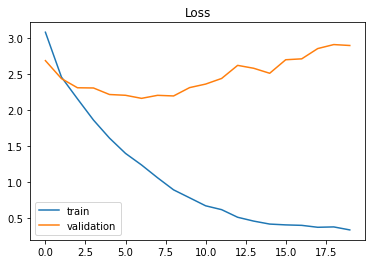

In [56]:
# Data Visualization
import matplotlib.pyplot as plt

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

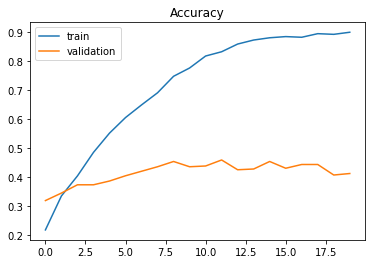

In [57]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()